### Model Definition 2

After running a few different tests below, we quickly encounter a number of issues that need to be handled for efficient model testing and training.  In the Model Definition 3 and subsequent notebooks we will attack these problems:

1. We need to track the metrics of various models and parameter combinations, with the ability to backtrack to a former configuration if we find we are going down the wrong path.  We will use Tensorboard for this 

2. We would like to be able to quickly test hyperparameters of our models without rewriting all of our code.  
 * We want to be able to add and remove layers to our models.
 * We want to experiment with model hyperparameters, such as the number and width of hidden layers, amount of dropout, bias, convolution stride size, and activation function.  
 * Algorithm hyperparameters  influence the speed and quality of the learning algorithm, such as learning rate of stochastic gradient descent.  
We will use Keras Tuner for this.

3. Once we have found a model and parameters that we think is working best, we want to train it as optimally as possible with our somewhat minimal data using the K-Folds technique.  We will use sklearn's KFold Cross Validation for this.

## Initial Model Exploration 
Our research into initial models for Text Classification used two models shown below:

### Phase 1: First test model: Embedding, 1D Convolutional model with GlobalMaxPooling

This model was based on a sample Text Classification task that we found.  We vectorized our data with a simple integer encoding.  It uses embedding to turn our input vectors into dense vectors of fixed size.  Word embeddings encode each word into a dense vector that learns about its relative meaning within the training text.  By sliding a convolutional window over the vectors, there is the increased possibility that training will learn the meaning of various word combinations more easily than single or double word (our ngrams) occurances.  Our activation layer uses sigmoid to refine our results to a binary classification.
```python
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
```

The results of our iniitial tests with this model are shown below.

### Phase 2: Second test model: 
This model was based on a second sample Text Classification task that we found.  We vectorized our data using tf-idf (term-frequency times inverse document-frequency), a common weighting scheme used for document classification (see Feature Engineering notebook for more).  It uses fully 3 connected dense layers alternating with Dropout layers. We experimented with tanh and relu activations in this notebook.  We will further test varying the dropout rate, possibly testing it at each layer. As above, our activation layer uses sigmoid to refine our results to a binary classification.

```python
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='tanh')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
```
The results of our iniitial tests with this model are shown below.

### A benchmark for comparison
Results of a similar text classification exercise are described in the article "FakeNewsTracker: A Tool for Fake News Collection, Detection, and Visualization," documented at http://sbp-brims.org/2018/proceedings/papers/challenge_papers/SBP-BRiMS_2018_paper_120.pdf  

The article describes using a combination of news stories and social media to identify fake news via machine learning.  Ultimately, the conclusion is that the combination of both news and social media data provides the best results for this type of text classification.

The table below shows the results.  The accuracy of 62-63% shown in the SAF/S column is a goal for our project.  (The SAF column has the results when both news and social media are used.)

(The BuzzFeed dataset used in this experiment is different than our Buzzfeed-Top one.)

<img src="https://raw.githubusercontent.com/adamx97/Data-Science-Advanced-Capstone/master/FakeNewsTracker_Comparison.png" />

We can consider testing our datasets separately as shown above to determine if we are more successful with some of the datasets than others.

In [ ]:
!pip install --upgrade numpy
!pip install --upgrade pandas

# we want tensorflow 2.3 
!pip install --upgrade tensorflow  

In [1]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
if not tf.__version__ == '2.3.1':
    raise ValueError('please upgrade to TensorFlow 2.3, or restart your Kernel (Kernel->Restart & Clear Output)')

Tensorflow version:  2.3.1


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from time import time
import logging
import numpy as np
import pandas as pd
import string
import re

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split

from ibm_botocore.client import Config
import ibm_boto3

In [3]:
#Get our data
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_news = {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'dfTrueFalseNews.pkl'
}

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print(' File Uploaded')
        
dfNews = download_file_cos(credentials_news, "dfTrueFalseNews.pkl", "dfTrueFalseNews.pkl")

File Downloaded


In [4]:
import matplotlib.pyplot as plt

def ChartModelHistory(fithistory, longdim=15, shortdim=10, horizontal=True):
    history_dict = fithistory.history
    history_dict.keys()
    if horizontal: 
        plt.figure(1, figsize=(longdim, shortdim))
        plt.subplot(121)
    else: 
        plt.figure(1, figsize=(shortdim,longdim))
        plt.subplot(211)


    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # zip joins x and y coordinates in pairs
    for x,y in zip(epochs,val_loss):

        label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center
    plt.legend()

    if horizontal:
        plt.subplot(122)
    else:
        plt.subplot(212)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    for x,y in zip(epochs,val_acc):

        label = "{:.2f}".format(y)

        plt.annotate(label, # this is the text
                    (x,y), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

    plt.legend()

    plt.show()

In [6]:
dfNews = pd.read_pickle('dfTrueFalseNews.pkl')
#dfNews['truthvalue'] = pd.Categorical(dfNews['truthvalue'])

print (dfNews.shape, dfNews.columns, '\n',  dfNews.dtypes)

(1126, 3) Index(['text', 'source', 'truthvalue'], dtype='object') 
 text          object
source        object
truthvalue    object
dtype: object


In [7]:
dfNews.head()

,text,source,truthvalue
tech003legit,A Google computer victorious over the world's ...,MihalceaNewsLegit,1
polit11legit,White House keeps up sanctuary cities pressure...,MihalceaNewsLegit,1
biz40legit,Why Silicon Valley isn't fighting to save the ...,MihalceaNewsLegit,1
edu10legit,Protesters Disrupt DeVos School Visit Protes...,MihalceaNewsLegit,1
tech038legit,Solar-powered 'skin' could make prosthetics mo...,MihalceaNewsLegit,1


In [8]:
x = dfNews['text'].values
y = dfNews['truthvalue'].values
print(type(x), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

# Once we have our handles, we format the datasets in a Keras-fit compatible
# format: a tuple of the form (text_data, label).
def format_dataset(x, y):
  return (x, y)

train_dataset = list(map(format_dataset, X_train, y_train))
test_dataset = list(map(format_dataset, X_test, y_test))

# We also create a dataset with only the textual data in it. This will be used
# to build our vocabulary later on.
textL_dataset = list(map(lambda a:a, x))


In [10]:
print (len(X_train), len(X_test), len(y_train), len(y_test), len(textL_dataset), '\n',
type(X_train), type(X_test), type(y_train), type(y_test), type(textL_dataset))


1013 113 1013 113 1126 
 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>


In [11]:
# move our numpy structures into Tensorflow datasets
Dataset = tf.data.Dataset
text_dataset = tf.data.Dataset.from_tensor_slices(textL_dataset)

features_dataset = Dataset.from_tensor_slices(X_train)
labels_dataset = Dataset.from_tensor_slices(list(y_train))
tfds_train = Dataset.zip((features_dataset, labels_dataset))

features_test_dataset = Dataset.from_tensor_slices(X_test)
labels_test_dataset = Dataset.from_tensor_slices(list(y_test))
tfds_test = Dataset.zip((features_test_dataset, labels_test_dataset))

## Phase 1: Model 1  basic vectorization and Embedding and Convolutional 1d model

In [26]:
# https://keras.io/examples/nlp/text_classification_from_scratch/
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers

# Model constants.
max_features = 26595 #vocabulary size
embedding_dim = 128

# We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer1 = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=500)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.
vectorize_layer1.adapt(text_dataset.batch(32))


# A text input.
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.
x = vectorize_layer1(text_input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'. Note that we're using max_features+1 here, since there's an
# OOV token that gets added to the vocabulary in vectorize_layer.
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)

x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model1 = tf.keras.Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model1.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/8
32/32 [==============================] - 7s 213ms/step - loss: 0.6960 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4956
Epoch 2/8
32/32 [==============================] - 6s 201ms/step - loss: 0.6943 - accuracy: 0.5114 - val_loss: 0.6931 - val_accuracy: 0.5133
Epoch 3/8
32/32 [==============================] - 6s 192ms/step - loss: 0.6909 - accuracy: 0.5360 - val_loss: 0.6925 - val_accuracy: 0.5133
Epoch 4/8
32/32 [==============================] - 6s 196ms/step - loss: 0.6785 - accuracy: 0.6002 - val_loss: 0.6895 - val_accuracy: 0.5133
Epoch 5/8
32/32 [==============================] - 6s 194ms/step - loss: 0.5521 - accuracy: 0.7493 - val_loss: 0.7455 - val_accuracy: 0.5841
Epoch 6/8
32/32 [==============================] - 6s 195ms/step - loss: 0.1595 - accuracy: 0.9457 - val_loss: 1.8896 - val_accuracy: 0.4956
Epoch 7/8
32/32 [==============================] - 6s 188ms/step - loss: 0.0252 - accuracy: 0.9911 - val_loss: 1.6200 - val_accuracy: 0.4956
Epoch 8/8
32/

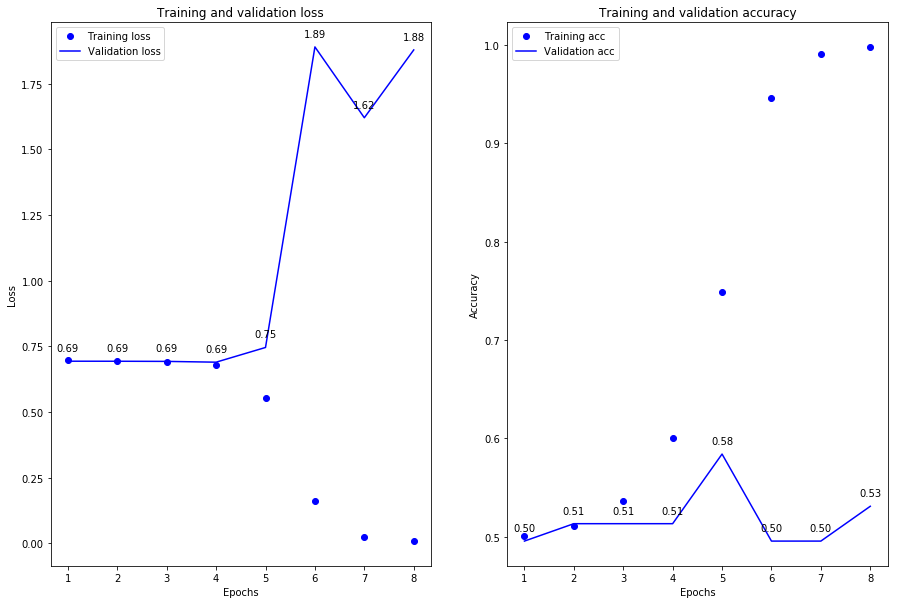

In [27]:
batch_size = 32
epochs = 8

# Fit the model using the train and test datasets.
history = model1.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)
ChartModelHistory(history)

In [ ]:
ChartModelHistory(history)

In [ ]:
# same as above with 1 stride and full vocabulary and bias
# Model constants.
#import ChartModelHistory as chm

max_features = 26595 # fulvocabulary size
embedding_dim = 128

# We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer1 = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=500)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.
vectorize_layer1.adapt(text_dataset.batch(64))


# A text input.
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.
x = vectorize_layer1(text_input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'. Note that we're using max_features+1 here, since there's an
# OOV token that gets added to the vocabulary in vectorize_layer.
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1, use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)

x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1, use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model1 = tf.keras.Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model1.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 64
epochs = 9

# Fit the model using the train and test datasets.
history = model1.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)
ChartModelHistory(history, horizontal=False)

In [ ]:
# same as above: Integer vectorizatoin, bias, and add regularization
# same as above with 1 stride and full vocabulary and bias
# Model constants.

max_features = 26595 # fulvocabulary size
embedding_dim = 128

# We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
from keras.regularizers import l2
vectorize_layer1 = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=500)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.
vectorize_layer1.adapt(text_dataset.batch(64))


# A text input.
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.
x = vectorize_layer1(text_input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'. Note that we're using max_features+1 here, since there's an
# OOV token that gets added to the vocabulary in vectorize_layer.
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1, use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)

x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1, use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42),
    activity_regularizer=l2(0.001))(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42),
    kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model1 = tf.keras.Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model1.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 64
epochs = 12

# Fit the model using the train and test datasets.
history = model1.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)
chm.ChartModelHistory(history, horizontal=False)



In [29]:
# Model 1 using 2 ngrams
vectorize_layer1 = TextVectorization(
    ngrams=2,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=500)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.
vectorize_layer1.adapt(text_dataset.batch(64))

text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer1(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model1 = tf.keras.Model(text_input, predictions)
model1.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 64
epochs = 12

# Fit the model using the train and test datasets.
history = model1.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)


Epoch 1/12
16/16 [==============================] - 16s 1s/step - loss: 0.6974 - accuracy: 0.4857 - val_loss: 0.6939 - val_accuracy: 0.4956
Epoch 2/12
16/16 [==============================] - 16s 1s/step - loss: 0.6953 - accuracy: 0.5015 - val_loss: 0.6927 - val_accuracy: 0.5044
Epoch 3/12
16/16 [==============================] - 16s 1s/step - loss: 0.6897 - accuracy: 0.5429 - val_loss: 0.6925 - val_accuracy: 0.5310
Epoch 4/12
16/16 [==============================] - 17s 1s/step - loss: 0.6914 - accuracy: 0.5449 - val_loss: 0.6918 - val_accuracy: 0.5487
Epoch 5/12
16/16 [==============================] - 17s 1s/step - loss: 0.6878 - accuracy: 0.5499 - val_loss: 0.6897 - val_accuracy: 0.5310
Epoch 6/12
16/16 [==============================] - 16s 969ms/step - loss: 0.6797 - accuracy: 0.5903 - val_loss: 0.6759 - val_accuracy: 0.6637
Epoch 7/12
16/16 [==============================] - 16s 1s/step - loss: 0.6290 - accuracy: 0.6821 - val_loss: 0.6113 - val_accuracy: 0.6372
Epoch 8/12
16/16 

NameError: name 'chm' is not defined

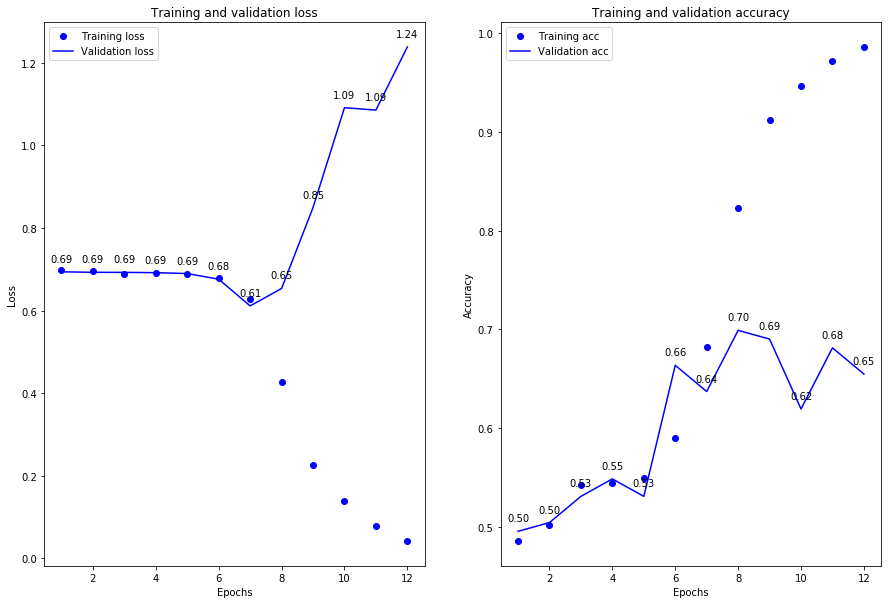

In [31]:
ChartModelHistory(history, horizontal=True)

In [ ]:
# Model 1 using 2 ngrams and bias and regularization
vectorize_layer1 = TextVectorization(
    ngrams=2,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=500)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.
vectorize_layer1.adapt(text_dataset.batch(64))

text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer1(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
#x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1, use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1, use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42),
    activity_regularizer=l2(0.001))(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42),
    kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model1 = tf.keras.Model(text_input, predictions)
model1.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 64
epochs = 9

# Fit the model using the train and test datasets.
history = model1.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)
chm.ChartModelHistory(history, horizontal=False)

In [ ]:
# Model 1 using 3 ngrams
vectorize_layer1 = TextVectorization(
    ngrams=3,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=500)

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.
vectorize_layer1.adapt(text_dataset.batch(64))

text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer1(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model1 = tf.keras.Model(text_input, predictions)
model1.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 64
epochs = 12

# Fit the model using the train and test datasets.
history = model1.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)
ChartModelHistory(history)

### Phase 1: Model 1 Discussion
This is the first model we tested and the two runs shown above seemed to reach peak accuracy in the 2 to 3 epoch range, though we will test them further as we move forward.  Using 2 ngrams (vs. single words) in our TextVectorization layer improved accuracy about 1.8%.

## Model 2 TextVectorization layer in a bigram TF-IDF densely-connected model

In [33]:
# Model constants.
#max_features = 14745 #vocabulary size
max_features = 26595 #vocabulary size


#We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer2 = TextVectorization(
    max_tokens=max_features,
    output_mode='tf-idf',
    ngrams=2,  # Unigrams and bigrams
    
    #output_sequence_length=500
    )

# Now that the vocab layer has been created, call `adapt` on the text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.
vectorize_layer2.adapt(text_dataset.batch(64))

# A text input.
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, features) containing TF-IDF features.
x = vectorize_layer2(text_input)

# Dense hidden layers
x = layers.Dense(256, activation='relu', use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42),
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42),
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', use_bias=True, 
    bias_initializer=tf.keras.initializers.GlorotNormal(seed=42),
    kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)

model2 = tf.keras.Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model2.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/10
32/32 [==============================] - 56s 2s/step - loss: 1.0753 - accuracy: 0.5232 - val_loss: 0.7155 - val_accuracy: 0.5752
Epoch 2/10
32/32 [==============================] - 56s 2s/step - loss: 1.0061 - accuracy: 0.6209 - val_loss: 0.7172 - val_accuracy: 0.6637
Epoch 3/10
32/32 [==============================] - 56s 2s/step - loss: 0.6475 - accuracy: 0.7384 - val_loss: 0.7945 - val_accuracy: 0.5929
Epoch 4/10
32/32 [==============================] - 56s 2s/step - loss: 0.4819 - accuracy: 0.8095 - val_loss: 0.8170 - val_accuracy: 0.5487
Epoch 5/10
32/32 [==============================] - 56s 2s/step - loss: 0.2925 - accuracy: 0.8885 - val_loss: 0.9448 - val_accuracy: 0.5841
Epoch 6/10
32/32 [==============================] - 56s 2s/step - loss: 0.2472 - accuracy: 0.9250 - val_loss: 1.0460 - val_accuracy: 0.5664
Epoch 7/10
32/32 [==============================] - 57s 2s/step - loss: 0.2606 - accuracy: 0.9260 - val_loss: 1.2540 - val_accuracy: 0.5398
Epoch 8/10
32/32 [==

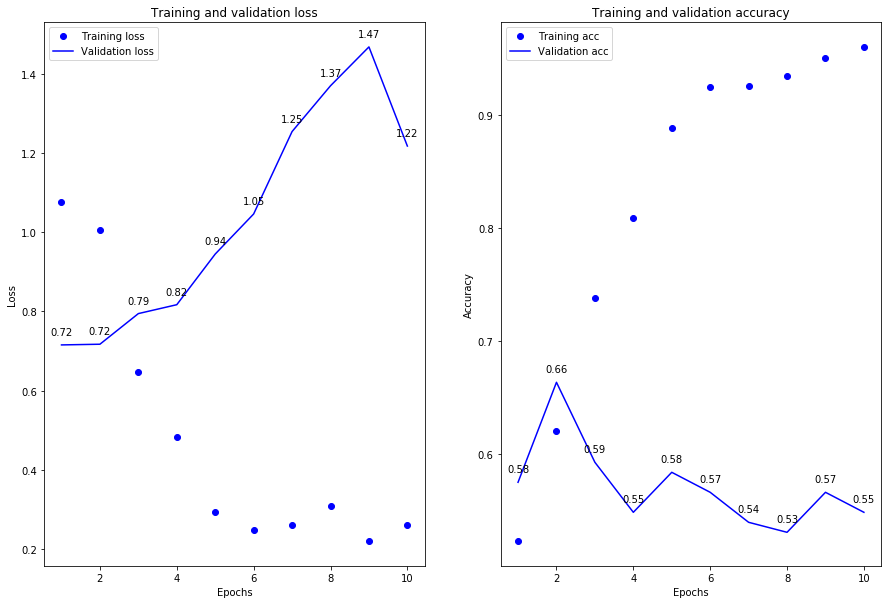

In [34]:
batch_size = 32
epochs = 10

# Fit the model using the train and test datasets.
history = model2.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)
ChartModelHistory(history, horizontal=True)

In [ ]:
# model 3 with Convolutional layers and tf-idf vectorization.
from keras.regularizers import l2
max_features = 26595 #vocabulary size
epochs = 14
batch_size=32
vectorize_layer3 = TextVectorization(max_tokens=max_features, output_mode='tf-idf',
    ngrams=2 )
vectorize_layer3.adapt(text_dataset.batch(64))
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer3(text_input)
x = layers.Embedding(max_features + 1, embedding_dim)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1,
        use_bias=True)(x)
x = layers.Conv1D(128, 7, padding='valid', activation='relu', strides=1, 
        use_bias=True)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
model3 = tf.keras.Model(text_input, predictions)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model3.fit(
    tfds_train.batch(batch_size),
    validation_data=tfds_test.batch(batch_size),
    epochs=epochs)
chm.ChartModelHistory(history, horizontal=False)


In [ ]:
#results = model2.evaluate(tfds_test)

#print(results)
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Results with 4 layers, 3 epochs: 

Layers were: 
```python
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
```

Accuracy is improving, but validation accuracy is not improving,  seems like overfitting.
```  Epoch 1/3
  15/15 [==============================] - 39s 3s/step - loss: 1.1349 - accuracy: 0.5039 - val_loss: 0.6969 - val_accuracy: 0.5531
  Epoch 2/3
  15/15 [==============================] - 39s 3s/step - loss: 0.7954 - accuracy: 0.6246 - val_loss: 0.7491 - val_accuracy: 0.5310
  Epoch 3/3
  15/15 [==============================] - 39s 3s/step - loss: 0.5594 - accuracy: 0.7619 - val_loss: 0.7448 - val_accuracy: 0.5354
  ```

Results with 6 layers, 3 epochs 128 units dense layer.
Layers were: 
```python
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
```

Both accuracy and val_accuracy are improving, seems better.
```
Epoch 1/3
15/15 [==============================] - 38s 3s/step - loss: 1.0789 - accuracy: 0.5028 - val_loss: 0.7001 - val_accuracy: 0.5265
Epoch 2/3
15/15 [==============================] - 37s 2s/step - loss: 0.9954 - accuracy: 0.5205 - val_loss: 0.6982 - val_accuracy: 0.5221
Epoch 3/3
15/15 [==============================] - 37s 2s/step - loss: 0.9662 - accuracy: 0.5692 - val_loss: 0.6842 - val_accuracy: 0.5708
```

Results with 6 layers, 3 epochs, 256 more units in the Dense layer. 18000 vocab
```python
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
```
```
Epoch 1/3
15/15 [==============================] - 35s 2s/step - loss: 1.3553 - accuracy: 0.4795 - val_loss: 0.7590 - val_accuracy: 0.4956
Epoch 2/3
15/15 [==============================] - 35s 2s/step - loss: 1.0434 - accuracy: 0.5703 - val_loss: 0.6703 - val_accuracy: 0.5575
Epoch 3/3
15/15 [==============================] - 35s 2s/step - loss: 0.8842 - accuracy: 0.6301 - val_loss: 0.6928 - val_accuracy: 0.5265
```

Results with 6 layers, 3 epochs, 256 units in Dense layer, and all single occurring words removed, leaving 14,745 vocabulary words.
`
Epoch 1/3
15/15 [==============================] - 29s 2s/step - loss: 1.2235 - accuracy: 0.4906 - val_loss: 0.8649 - val_accuracy: 0.4823
Epoch 2/3
15/15 [==============================] - 28s 2s/step - loss: 1.0063 - accuracy: 0.5847 - val_loss: 0.6744 - val_accuracy: 0.6062
Epoch 3/3
15/15 [==============================] - 28s 2s/step - loss: 0.7222 - accuracy: 0.6611 - val_loss: 0.6706 - val_accuracy: 0.5664
`

### Replace dense layer with tanh activation layer:
```
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='tanh')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
```
Results with 6 layers, 6 epochs, 256 units in Dense layer, middle layer w/ tanh activation and all single occurring words removed, leaving 14,745 vocabulary words.
```
Epoch 1/6
15/15 [==============================] - 29s 2s/step - loss: 0.8455 - accuracy: 0.5083 - val_loss: 0.6888 - val_accuracy: 0.5221
Epoch 2/6
15/15 [==============================] - 28s 2s/step - loss: 0.7452 - accuracy: 0.5703 - val_loss: 0.7091 - val_accuracy: 0.5000
Epoch 3/6
15/15 [==============================] - 28s 2s/step - loss: 0.7064 - accuracy: 0.6213 - val_loss: 0.6763 - val_accuracy: 0.5796
Epoch 4/6
15/15 [==============================] - 28s 2s/step - loss: 0.5463 - accuracy: 0.7276 - val_loss: 0.7541 - val_accuracy: 0.5619
Epoch 5/6
15/15 [==============================] - 28s 2s/step - loss: 0.3879 - accuracy: 0.8295 - val_loss: 0.9690 - val_accuracy: 0.5841
Epoch 6/6
15/15 [==============================] - 28s 2s/step - loss: 0.2275 - accuracy: 0.9037 - val_loss: 1.1818 - val_accuracy: 0.5929
```

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Results with 6 layers, 3 epochs, 256 more units in the Dense layer. 20000 vocab
```
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
```
```
Epoch 1/3
15/15 [==============================] - 38s 3s/step - loss: 1.2857 - accuracy: 0.5316 - val_loss: 0.7208 - val_accuracy: 0.5398
Epoch 2/3
15/15 [==============================] - 38s 3s/step - loss: 1.1039 - accuracy: 0.5703 - val_loss: 0.6790 - val_accuracy: 0.5664
Epoch 3/3
15/15 [==============================] - 38s 3s/step - loss: 0.9360 - accuracy: 0.6523 - val_loss: 0.6857 - val_accuracy: 0.5885
```

Results with 6 layers, 3 epochs, 256 units in dense layer, 25000 vocab.
```x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

Epoch 1/3
15/15 [==============================] - 49s 3s/step - loss: 1.6061 - accuracy: 0.5017 - val_loss: 0.6888 - val_accuracy: 0.5044
Epoch 2/3
15/15 [==============================] - 48s 3s/step - loss: 1.0667 - accuracy: 0.5415 - val_loss: 0.7125 - val_accuracy: 0.4912
Epoch 3/3
15/15 [==============================] - 48s 3s/step - loss: 1.0003 - accuracy: 0.6456 - val_loss: 0.6951 - val_accuracy: 0.5221
```

In [ ]:
model2.summary()

### Phase 2: Model 2 Discussion

This is the second model we tested. The primary difference from the first model is the textvectorization (tf-idf weighting vs. unweighted integer) and fully connected dense layers vs convolutional wones.   Here we extended our epochs to 6 and found that indeed, the 2nd or 3rd epoch tended to give the best results.  
 
We also varied activation layers (relu vs. tanh) and vocabulary size.  

Making multiple changes to our test in multiple dimensions made clear the challenges of maintaining clear notes concerning the model parameters and results obtained. the two runs shown above seemed to reach peak accuracy in the 2 to 3 epoch range, though we will test them further as we move forward. 

Thus we are motivated to put together a clearly structured lab environment for testing models, parameters, and storing results.  Luckily Tensorflow provides much of the framework for this.  This work is continued in the next notebook.


